# Deliverables



1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [152]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import split_scale
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.metrics import median_absolute_error, r2_score
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from pygam import LinearGAM, s, f, te
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

In [2]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [3]:
# check DF head
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30


In [4]:
# check DF tail
df.tail(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [5]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [6]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [7]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [8]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [9]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [10]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [11]:
# add some logrithmic variables
df['log2sf'] = np.log2(df['square_feet'])
df['log2lot_size'] = np.log2(df['lot_size'])
df['log2value'] = np.log2(df['assessed_value'])
df['age'] = 2000-df.year_built

In [12]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045,Los Angles,10.509775,13.016112,17.054350,30
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270,Los Angles,10.472691,12.711452,15.119833,89


In [13]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [14]:
#create a subset of df with continuous variables to create pairplot
train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'lot_size', 'assessed_value']]

In [ ]:
explore.plot_variable_pairs(train_plot)

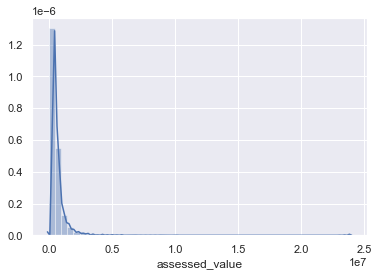

In [15]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [16]:
cm = train_plot.corr()
cm

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
bathrooms,1.000000,0.641827,0.854944,0.159933,0.505229
bedrooms,0.641827,1.000000,0.628387,0.087423,0.263875
square_feet,0.854944,0.628387,1.000000,0.206333,0.588502
lot_size,0.159933,0.087423,0.206333,1.000000,0.131576
assessed_value,0.505229,0.263875,0.588502,0.131576,1.000000


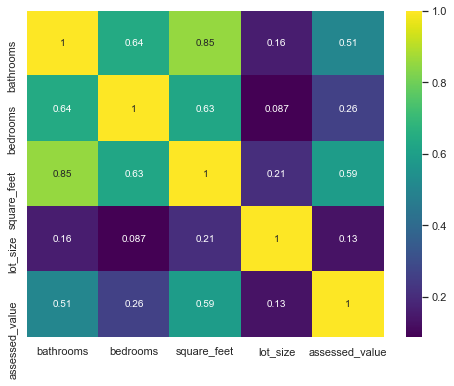

In [17]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

# $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
# $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [18]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['bedrooms', 'bathrooms', 'square_feet']]
y_train = train[['assessed_value']]
X_test = test[['bedrooms', 'bathrooms', 'square_feet']]
y_test = test[['assessed_value']]

In [19]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.assessed_value
})
predictions.head(2)

,actual
11938,268557.0
790,95849.0


In [20]:
predictions['median_bl'] =  train['assessed_value'].median()

In [21]:
predictions.head(2)

,actual,median_bl
11938,268557.0,389610.0
790,95849.0,389610.0


In [22]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('assessed_value ~ bedrooms + bathrooms + square_feet', data = train).fit()

# compute predictions and add to original dataframe
predictions['ols'] = ols_model.predict(X_train)

In [23]:
predictions.head(2)

,actual,median_bl,ols
11938,268557.0,389610.0,718051.869254
790,95849.0,389610.0,316295.362143


In [24]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: median_absolute_error(predictions.actual, col))

actual           0.000
median_bl   209842.000
ols         193941.156
dtype: float64

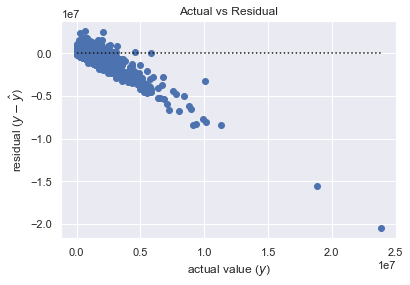

In [25]:
#Lets look at residuals
evaluate.plot_residuals(predictions.actual, predictions.ols, predictions)

# Looks like there is a clear trend. The model seems to be doing well at lower home values, but diverges 
#significantly at higher price levels. 

In [26]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         assessed_value   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     2007.
Date:                Thu, 09 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:11:38   Log-Likelihood:            -1.5278e+05
No. Observations:               10411   AIC:                         3.056e+05
Df Residuals:                   10407   BIC:                         3.056e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5989.8197    2.1e+04     -0.285      0.776   -4.72e+04    3.52e+04
bedrooms    -1.465e+05   8045.351    -18.211      0.000   -1.62e+05   -1.31e+05
bathrooms    5.748e+04    1.1e+04      5.220      0.000    3.59e+04    7.91e+04
square_feet   465.3172     11.199     41.549      0.000     443.364     487.270
==============================================================================
Omnibus:                    16670.764   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26785887.300
Skew:                          10.040   Prob(JB):                         0.00
Kurtosis:                     250.679   Cond. No.                     8.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Since my p-value is <0.05, I can reject my null hypothesis.
# This means that there is statistically significant relationship between home prices and  independent variables used above.

-------------------------------

# Lets apply this model on test data and see how it performs

In [27]:
y_test['y_ols'] = ols_model.predict(X_test)

In [28]:
y_test

,assessed_value,y_ols
9116,1352462.000,1043773.901
2397,797339.000,981994.199
2849,63577.000,212001.736
14308,621836.000,874988.914
9780,362761.000,601006.905
...,...,...
13270,1085000.000,697112.596
14751,80182.000,460481.114
2874,292624.000,560524.310
7178,501586.000,592631.196


In [29]:
y_test.apply(lambda col: median_absolute_error(y_test.assessed_value, col))

assessed_value        0.000
y_ols            192265.741
dtype: float64

# The Median Absolute Error for test data is comparable to train data which means that model is not overfitted

-----------------------------------------------------

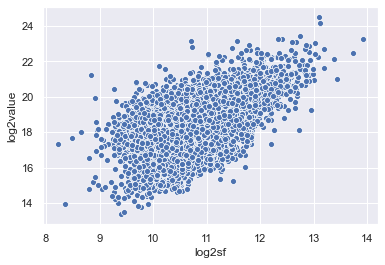

In [30]:
sns.scatterplot(x='log2sf', y = 'log2value', data=train)

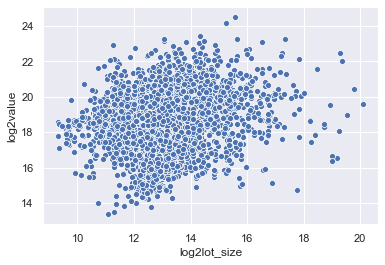

In [31]:
sns.scatterplot(x='log2lot_size', y = 'log2value', data=train)

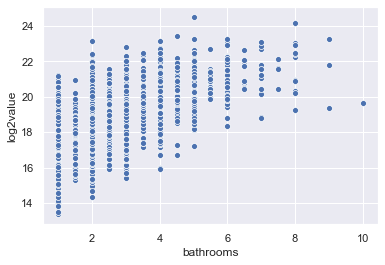

In [32]:
sns.scatterplot(x='bathrooms', y = 'log2value', data=train)

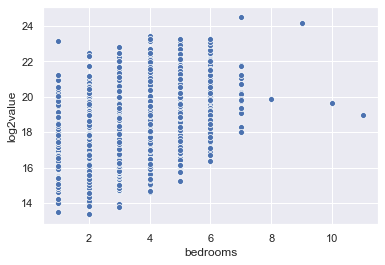

In [33]:
sns.scatterplot(x='bedrooms', y = 'log2value', data=train)

# may be we should try to fit a polynomial function to predict price using log2sf

In [34]:
X_train = train[[ 'log2sf']]
y_train = train[['log2value']]
X_test = test[['log2sf']]
y_test = test[['log2value']]

In [35]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly.get_feature_names()

['1', 'x0', 'x0^2']

In [36]:
X_poly[1]

array([  1.        ,  10.73555602, 115.25216314])

In [37]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

In [38]:
y_train['actual'] = 2**y_train.log2value
y_train['lm_predicted'] = 2**y_train.yhat_poly
y_train['median_bl'] =  train['assessed_value'].median()

In [39]:
y_train

,log2value,yhat_poly,actual,lm_predicted,median_bl
11938,18.035,18.644,268557.000,409742.221,389610.000
790,16.548,18.261,95849.000,314099.664,389610.000
3846,18.308,18.542,324613.000,381743.173,389610.000
14846,18.931,18.855,499860.000,474005.716,389610.000
1469,18.982,17.932,517777.000,250146.981,389610.000
...,...,...,...,...,...
12119,20.333,19.033,1321024.000,536410.151,389610.000
8039,18.771,17.930,447349.000,249643.893,389610.000
14147,19.344,18.022,665588.000,266197.453,389610.000
6936,18.985,19.002,518732.000,525084.385,389610.000


In [40]:
y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

log2value      389591.428
yhat_poly      389591.999
actual              0.000
lm_predicted   171218.494
median_bl      209842.000
dtype: float64

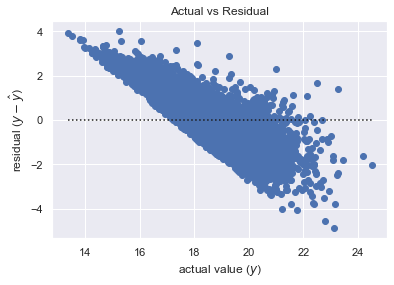

In [41]:
evaluate.plot_residuals(y_train.log2value, y_train.yhat_poly, predictions)

In [42]:
lm = LinearRegression()

In [43]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
y_train['lm_log2'] = lm.predict(X_train)

ValueError: Wrong number of items passed 5, placement implies 1

In [ ]:
y_train['actual'] = 2**y_train.log2value
y_train['lm_predicted'] = 2**y_train.lm_log2
y_train['median_bl'] =  train['assessed_value'].median()

In [45]:
y_train.head()

,log2value,yhat_poly,actual,lm_predicted,median_bl
11938,18.035,18.644,268557.000,409742.221,389610.000
790,16.548,18.261,95849.000,314099.664,389610.000
3846,18.308,18.542,324613.000,381743.173,389610.000
14846,18.931,18.855,499860.000,474005.716,389610.000
1469,18.982,17.932,517777.000,250146.981,389610.000
...,...,...,...,...,...
12119,20.333,19.033,1321024.000,536410.151,389610.000
8039,18.771,17.930,447349.000,249643.893,389610.000
14147,19.344,18.022,665588.000,266197.453,389610.000
6936,18.985,19.002,518732.000,525084.385,389610.000


In [46]:
y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

log2value      389591.428
yhat_poly      389591.999
actual              0.000
lm_predicted   171218.494
median_bl      209842.000
dtype: float64

In [47]:
X_train = train[['bathrooms', 'log2sf', 'latitude', 'longitude']]
y_train = train[['log2value']]
X_test = test[[ 'bathrooms', 'log2sf','latitude', 'longitude']]
y_test = test[['log2value']]

In [48]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [49]:
X_train[1]

array([ 2.00000000e+00,  1.07355560e+01,  3.41788210e+07, -1.18607295e+08])

In [50]:
gam = LinearGAM(s(0) + s(1) + te(2,3))

In [51]:
gam .gridsearch(X_train,y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + te(2, 3) + intercept,
   tol=0.0001, verbose=False)

In [52]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     86.1077
Link Function:                     IdentityLink Log Likelihood:                                -15080.7417
Number of Samples:                        10411 AIC:                                            30335.6988
                                                AICc:                                           30337.1858
                                                GCV:                                                1.0832
                                                Scale:                                               1.067
                                                Pseudo R-Squared:                                    0.438
Feature Function                  Lam

In [53]:
y_pred = gam.predict(X_train)

In [54]:
y_pred

array([17.70762064, 18.20448626, 18.61546867, ..., 18.2438443 ,
       18.86876733, 17.89814895])

In [55]:
y_pred = pd.DataFrame(y_pred)

In [56]:
y_pred['actual'] =y_train

In [57]:
y_pred.head(2)

,0,actual
0,17.708,18.035
1,18.204,16.548


In [58]:
y_pred['actual1'] = 2**y_pred.actual
y_pred['predicted1'] = 2**y_pred[0]

In [59]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual1, col))

0            389591.883
actual       389591.428
actual1           0.000
predicted1   156415.307
dtype: float64

# Create a new parameter - Median value of house in that particular zip_code

In [60]:
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,136104.000,2319.900,2017-06-23,0.017,Los Angles,10.510,13.016,17.054,30
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,35606.000,543.690,2017-06-30,0.015,Los Angles,10.473,12.711,15.120,89
2,3.000,4.000,2541.000,6059,4975,0,96958,2003,33694636.000,-117912245.000,880456.000,9819.720,2017-06-01,0.011,Orange,11.311,12.280,19.748,-3
3,2.000,3.000,1650.000,6037,7300,0,96037,1949,33985377.000,-118361620.000,614000.000,7673.190,2017-06-01,0.012,Los Angles,10.688,12.834,19.228,51
4,1.000,2.000,693.000,6037,2908,0,96023,1921,34112946.000,-118208106.000,274237.000,3267.470,2017-06-29,0.012,Los Angles,9.437,11.506,18.065,79


In [61]:
zip1 = df.zip_code

In [109]:
list1 = list(zip1)

In [81]:
(df[df.zip_code == list1[3]]).assessed_value.median()

653668.5

In [84]:
def median_v(df, l):
    list2 = []
    for i in range(0, len(l)):
        median1 = (df[df.zip_code == l[i]]).assessed_value.median()
        list2.append(median1)
    return list2

In [102]:
list3 = median_v(df, list1)

In [103]:
list3 = pd.DataFrame(list3, columns=['zip_median'])

In [106]:
df = pd.concat([df, list3], axis=1)

In [108]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,0,zip_median
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,...,2319.900,2017-06-23,0.017,Los Angles,10.510,13.016,17.054,30,144172.000,144172.000
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,...,543.690,2017-06-30,0.015,Los Angles,10.473,12.711,15.120,89,162337.000,162337.000


In [110]:
df['log2_zip_median'] = np.log2(df['zip_median'])

In [111]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,0,zip_median,log2_zip_median
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,...,2017-06-23,0.017,Los Angles,10.510,13.016,17.054,30,144172.000,144172.000,17.137
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,...,2017-06-30,0.015,Los Angles,10.473,12.711,15.120,89,162337.000,162337.000,17.309


In [134]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [135]:
X_train = train[[ 'log2sf','log2_zip_median']]
y_train = train[['log2value']]
X_test = test[['log2sf','log2_zip_median']]
y_test = test[['log2value']]

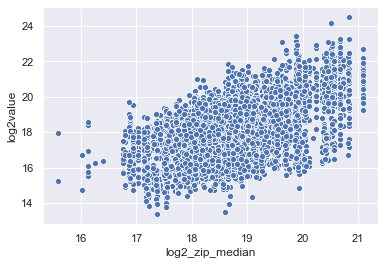

In [136]:
sns.scatterplot(x='log2_zip_median', y = 'log2value', data=train)

In [137]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly.get_feature_names()

['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [138]:
X_poly = pd.DataFrame(poly.transform(X_train), columns=poly.get_feature_names(X_train.columns))
X_poly

,1,log2sf,log2_zip_median,log2sf^2,log2sf log2_zip_median,log2_zip_median^2
0,1.000,11.057,17.865,122.249,197.525,319.154
1,1.000,10.736,19.117,115.252,205.235,365.473
2,1.000,10.976,19.117,120.469,209.823,365.453
3,1.000,11.214,18.920,125.761,212.179,357.982
4,1.000,10.409,18.602,108.355,193.639,346.046
...,...,...,...,...,...,...
10406,1.000,11.340,20.032,128.605,227.171,401.282
10407,1.000,10.406,18.465,108.289,192.149,340.952
10408,1.000,10.505,18.186,110.351,191.045,330.747
10409,1.000,11.319,19.517,128.122,220.910,380.895


In [139]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.log2value)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

In [148]:
y_train.head()

,log2value,yhat_poly,actual,lm_poly_predicted,median_bl
11938,18.035,18.009,268557.000,263821.642,389610.000
790,16.548,18.611,95849.000,400412.359,389610.000
3846,18.308,18.795,324613.000,454884.410,389610.000
14846,18.931,18.878,499860.000,481880.909,389610.000
1469,18.982,18.046,517777.000,270631.440,389610.000


In [141]:
y_train['actual'] = 2**y_train.log2value
y_train['lm_poly_predicted'] = 2**y_train.yhat_poly
y_train['median_bl'] =  train['assessed_value'].median()

In [142]:
y_train.head(2)

,log2value,yhat_poly,actual,lm_poly_predicted,median_bl
11938,18.035,18.009,268557.000,263821.642,389610.000
790,16.548,18.611,95849.000,400412.359,389610.000


In [143]:
y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

log2value           389591.428
yhat_poly           389591.680
actual                   0.000
lm_poly_predicted   153119.769
median_bl           209842.000
dtype: float64

In [144]:
y_train.apply(lambda col: sqrt(mean_squared_error(y_train.actual, col)))

log2value           900880.249
yhat_poly           900880.569
actual                   0.000
lm_poly_predicted   536019.373
median_bl           734625.255
dtype: float64

In [147]:
y_train.apply(lambda col: r2_score(y_train.actual, col))

log2value           -0.573
yhat_poly           -0.573
actual               1.000
lm_poly_predicted    0.443
median_bl           -0.046
dtype: float64

In [149]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [158]:
X_train = train[[ 'log2sf','log2_zip_median']]
y_train = train[['log2value']]
X_test = test[['log2sf','log2_zip_median']]
y_test = test[['log2value']]

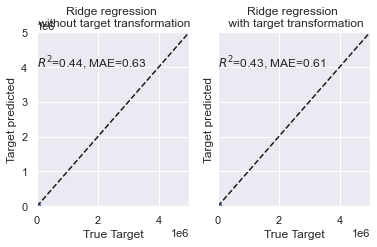

In [159]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)

ax0.scatter(y_train, y_pred)
ax0.plot([0, 5000000], [0, 5000000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax0.set_xlim([0, 5000000])
ax0.set_ylim([0, 5000000])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_train)

ax1.scatter(y_train, y_pred)
ax1.plot([0, 5000000], [0, 5000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax1.set_xlim([0, 5000000])
ax1.set_ylim([0, 5000000])

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()